This is an adaptation of the 1.6 with MediaPipe hand model for additin hand detection


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.3 MB/s eta 0:00:00


In [3]:
pip install albumentations

In [4]:
pip install mediapipe opencv-python-headless tensorflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 27.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manyl

In [5]:
pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 5.3 MB/s eta 0:00:00


In [26]:
from tensorflow.keras.preprocessing import image
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, ModelCheckpoint


from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, DepthwiseConv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import math
import keras_tuner as kt
from keras_tuner import HyperModel
import tensorflow as tf

import albumentations as A
from tensorflow.keras.utils import Sequence
import cv2

from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from shutil import copyfile
import os

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report

from tensorflow.keras.applications import MobileNet

import mediapipe as mp
from sklearn.utils.class_weight import compute_class_weight

import visualkeras




processedBSL_data = '/content/drive/MyDrive/FP/Dataset/dataset2/BSL Digits_resize&pad1'




Hand detection

In [7]:
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.5)

def process_and_save_images(source_dir, target_dir):
    if not os.path.exists(target_dir):
        os.makedirs(target_dir, exist_ok=True)

    for class_name in os.listdir(source_dir):
        class_dir = os.path.join(source_dir, class_name)
        target_class_dir = os.path.join(target_dir, class_name)
        os.makedirs(target_class_dir, exist_ok=True)

        for img_file in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_file)
            img = cv2.imread(img_path)
            if img is not None:
                results = hands.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                if results.multi_hand_landmarks:
                    for hand_landmarks in results.multi_hand_landmarks:
                        # For simplicity, use the bounding box of the first detected hand
                        hand_img = crop_hand_from_image(img, hand_landmarks)
                        if hand_img is not None:
                            cv2.imwrite(os.path.join(target_class_dir, img_file), hand_img)
                        break  # Remove this line if you want to process multiple hands within the same image

def crop_hand_from_image(img, hand_landmarks):
    image_height, image_width, _ = img.shape
    landmark_coords = [(int(landmark.x * image_width), int(landmark.y * image_height)) for landmark in hand_landmarks.landmark]
    x_coords, y_coords = zip(*landmark_coords)
    x_min, x_max = min(x_coords), max(x_coords)
    y_min, y_max = min(y_coords), max(y_coords)
    # Expand the bounding box slightly to include the whole hand
    x_min, x_max = max(0, x_min - 10), min(image_width, x_max + 10)
    y_min, y_max = max(0, y_min - 10), min(image_height, y_max + 10)
    return img[y_min:y_max, x_min:x_max]

mediapipe_mn_dataset = '/content/drive/MyDrive/FP/MobileNet/processed_with_mediapipe5'
process_and_save_images(processedBSL_data, mediapipe_mn_dataset)

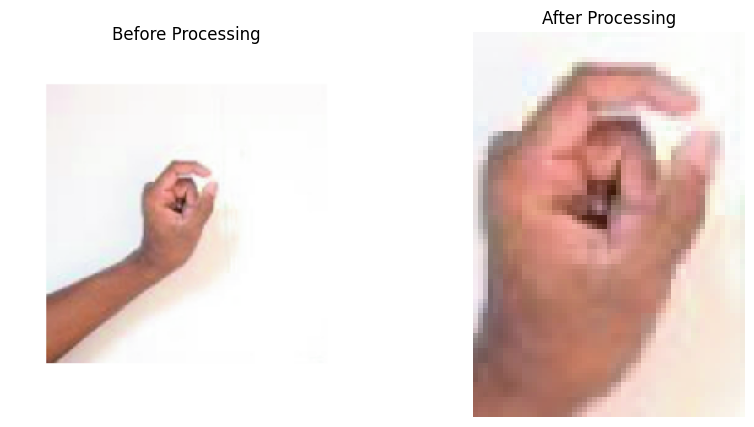

In [8]:
def show_images(before, after):
  fig, ax = plt.subplots(1, 2, figsize=(10, 5))
  ax[0].imshow(cv2.cvtColor(cv2.imread(before), cv2.COLOR_BGR2RGB))
  ax[0].set_title('Before Processing')
  ax[0].axis('off')

  ax[1].imshow(cv2.cvtColor(cv2.imread(after), cv2.COLOR_BGR2RGB))
  ax[1].set_title('After Processing')
  ax[1].axis('off')

  plt.show()


after_image = '/content/drive/MyDrive/FP/MobileNet/processed_with_mediapipe4/Input - 0/0 (1).png'
before_image = '/content/drive/MyDrive/FP/Dataset/dataset2/BSL Digits_resize&pad1/Input - 0/0 (1).png'
show_images(before_image, after_image)

Normalisation

In [9]:
from sklearn.model_selection import train_test_split
from shutil import copyfile
import os

train_path ='/content/drive/MyDrive/FP/MobileNet/Data_Split/hd_dataset_split5/train'
validation_path ='/content/drive/MyDrive/FP/MobileNet/Data_Split/hd_dataset_split5/validation'
test_path ='/content/drive/MyDrive/FP/MobileNet/Data_Split/hd_dataset_split5/test'

test_split_size = 0.2
validation_split_size_from_train = 0.25

for class_name in os.listdir(mediapipe_mn_dataset):
    # Create paths for each class in train, validation, and test directories
    os.makedirs(os.path.join(train_path, class_name), exist_ok=True)
    os.makedirs(os.path.join(validation_path, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_path, class_name), exist_ok=True)

    # List all files in the current class directory
    class_dir = os.path.join(mediapipe_mn_dataset, class_name)
    all_files = [os.path.join(class_dir, f) for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]

    # Split the data into training+validation and testing sets
    train_val_files, test_files = train_test_split(all_files, test_size=test_split_size, random_state=42)

    # Split the training+validation set into separate training and validation sets
    train_files, validation_files = train_test_split(train_val_files, test_size=validation_split_size_from_train, random_state=42)

    # Function to copy files to the new directory structure
    def copy_files(files, destination):
        for f in files:
            basename = os.path.basename(f)
            copyfile(f, os.path.join(destination, class_name, basename))

    # Copy files to their new locations
    copy_files(train_files, train_path)
    copy_files(validation_files, validation_path)
    copy_files(test_files, test_path)



Augmentation



In [10]:
image_paths = []
labels = []

for label in os.listdir(train_path):
    class_dir = os.path.join(train_path, label)

    if os.path.isdir(class_dir):
        for img_file in os.listdir(class_dir):
            # Add the image path to `image_paths`
            image_paths.append(os.path.join(class_dir, img_file))

            labels.append(label)


In [28]:
class AlbumentationsImageDataGenerator(Sequence):
    def __init__(self, image_paths, labels, batch_size, img_size, augmentations):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.augmentations = augmentations

    def __len__(self):
        return len(self.image_paths) // self.batch_size

    def __getitem__(self, idx):
        batch_paths = self.image_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_labels = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        batch_images = []
        for image_path in batch_paths:
            img = cv2.imread(image_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = self.augmentations(image=img)['image']
            img = preprocess_input(img)
            batch_images.append(img)

        return np.array(batch_images), np.array(batch_labels)

    @property
    def samples(self):
      return len(self.image_paths)

augmentations = A.Compose([
    A.Resize(height=224, width=224),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=20, p=0.9),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.RandomCrop(height=224, width=224, always_apply=True),
    A.GaussianBlur(blur_limit=(1, 3), p=0.1),
])

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)  # No augmentation for validation
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)  # No augmentation for testing

encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels) #encode labels to integers
one_hot_labels = to_categorical(encoded_labels, num_classes=10)

train_generator = AlbumentationsImageDataGenerator(
    image_paths=image_paths,
    labels=one_hot_labels,
    batch_size=20,
    img_size=224,
    augmentations=augmentations
)
#summary of train
num_classes = len(np.unique(encoded_labels))
num_images = train_generator.samples

print(f"Found {num_images} images belonging to {num_classes} classes.")


test_generator = test_datagen.flow_from_directory(test_path, target_size = (224, 224), batch_size = 20, class_mode='categorical', shuffle=False)

validation_generator = validation_datagen.flow_from_directory(validation_path, target_size = (224, 224), batch_size = 20, class_mode='categorical', shuffle=False)




Found 600 images belonging to 10 classes.
Found 200 images belonging to 10 classes.
Found 200 images belonging to 10 classes.


MobileNet model building

In [15]:
base_model = MobileNet(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Create a custom top layers for our dataset
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # Add a fully connected layer
x = Dropout(0.5)(x)  # Dropout layer to reduce overfitting
predictions = Dense(10, activation='softmax')(x)  # New output layer for 10 classes

# Connect the base model with new top layers
mnetmodel = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
mnetmodel.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

#callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, verbose=1, mode='min', min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
#Learning Rate Sceduling
def scheduler(epoch, lr):
  if epoch < 5:
    return lr
  else:
    return lr * tf.math.exp(-0.1)
#instantaiting the lr scheduler callback
lr_schedule = LearningRateScheduler(scheduler)

#implmenting ModelCheckpoint to monitor the validation acc and save the best model
model_checkpoint = ModelCheckpoint(
    filepath= '/content/drive/MyDrive/FP/MobileNet/Model/BSL_MobileNet_HD_build_mobilenet_hyper5.h5',
    save_best_only= True,
    monitor='val_accuracy',
    mode='max',
    verbose=1)

callbacks_list = [reduce_lr, early_stopping, lr_schedule, model_checkpoint]

total_train_samples = train_generator.samples
total_validation_samples = validation_generator.samples
batch_size = 20

steps_per_epoch = len(train_generator)
validation_steps = len(validation_generator)


mnethistory = mnetmodel.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks_list)

17225924/17225924 [==============================] - 0s 0us/step
Epoch 1/30
30/30 [==============================] - ETA: 0s - loss: 2.8971 - accuracy: 0.1417
Epoch 1: val_accuracy improved from -inf to 0.88000, saving model to /content/drive/MyDrive/FP/MobileNet/Model/BSL_MobileNet_HD_build_mobilenet_hyper5.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


30/30 [==============================] - 13s 247ms/step - loss: 2.8971 - accuracy: 0.1417 - val_loss: 1.2583 - val_accuracy: 0.8800 - lr: 1.0000e-04
Epoch 2/30
30/30 [==============================] - ETA: 0s - loss: 1.2737 - accuracy: 0.6050
Epoch 2: val_accuracy improved from 0.88000 to 0.96000, saving model to /content/drive/MyDrive/FP/MobileNet/Model/BSL_MobileNet_HD_build_mobilenet_hyper5.h5
30/30 [==============================] - 7s 220ms/step - loss: 1.2737 - accuracy: 0.6050 - val_loss: 0.5998 - val_accuracy: 0.9600 - lr: 1.0000e-04
Epoch 3/30
30/30 [==============================] - ETA: 0s - loss: 0.6518 - accuracy: 0.8433
Epoch 3: val_accuracy improved from 0.96000 to 1.00000, saving model to /content/drive/MyDrive/FP/MobileNet/Model/BSL_MobileNet_HD_build_mobilenet_hyper5.h5
30/30 [==============================] - 7s 231ms/step - loss: 0.6518 - accuracy: 0.8433 - val_loss: 0.2751 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 4/30
30/30 [==============================] - E

In [16]:
mnetmodel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128   

In [19]:
visualkeras.layered_view(mnetmodel, to_file='/content/drive/MyDrive/FP/MobileNet/mobilenetmodel_visual.png').show()

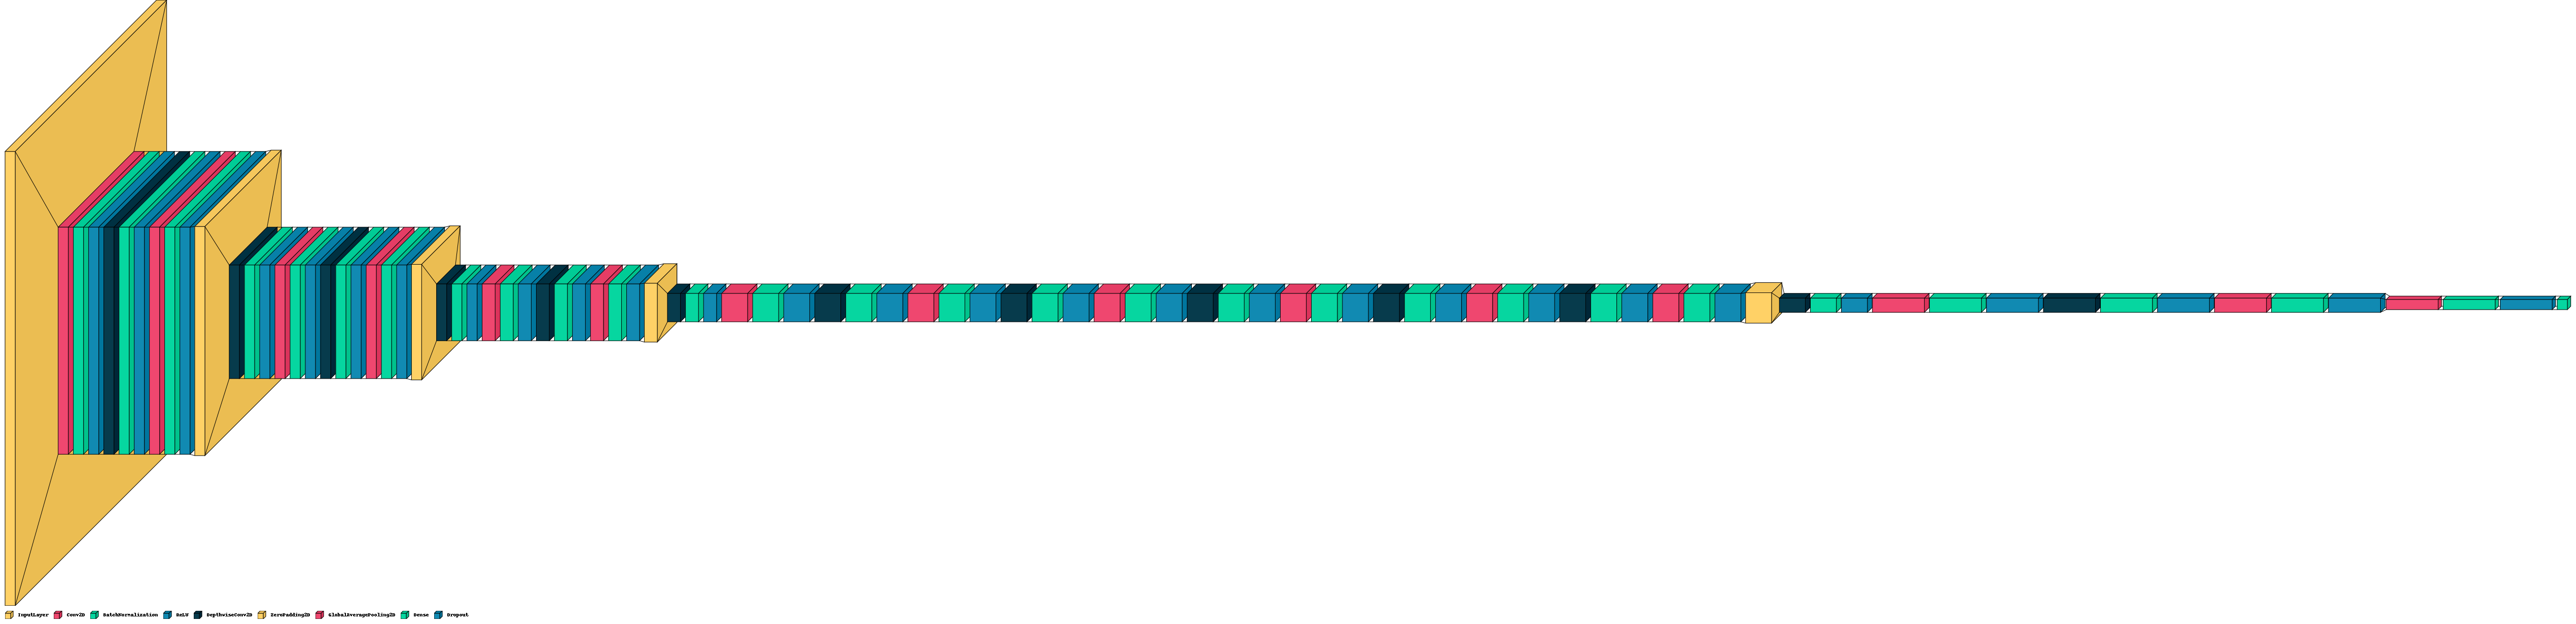

In [20]:
visualkeras.layered_view(mnetmodel, legend=True)

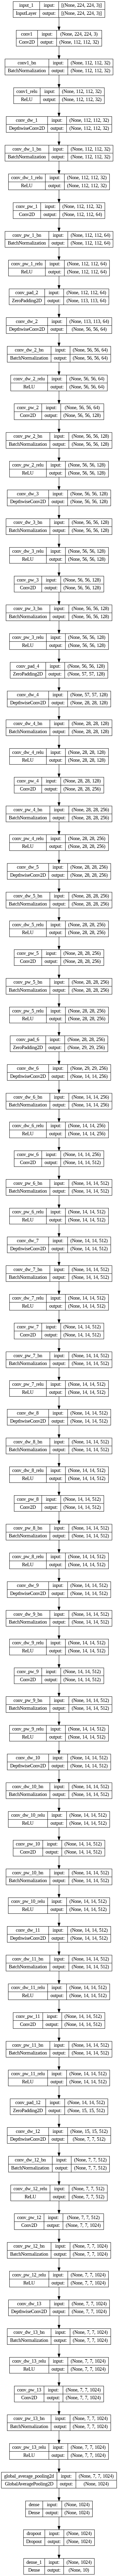

In [48]:
from tensorflow.keras.utils import plot_model
plot_model(mnetmodel, to_file='/content/drive/MyDrive/FP/MobileNet/mnetmodel_visual1.png', show_shapes=True, show_layer_names=True)

Evaluatio based on testing set

In [21]:
steps = validation_generator.samples / batch_size

val_loss, val_acc = mnetmodel.evaluate(validation_generator, steps=steps)
print("Validation Accuracy:", val_acc)

10/10 [==============================] - 1s 111ms/step - loss: 0.0115 - accuracy: 1.0000
Validation Accuracy: 1.0


In [22]:
test_loss, test_accuracy = mnetmodel.evaluate(test_generator, steps=test_generator.samples/test_generator.batch_size)
print("Test loss: ", test_loss)
print("Test accuracy: ", test_accuracy)


10/10 [==============================] - 1s 93ms/step - loss: 0.0133 - accuracy: 1.0000
Test loss:  0.013316433876752853
Test accuracy:  1.0


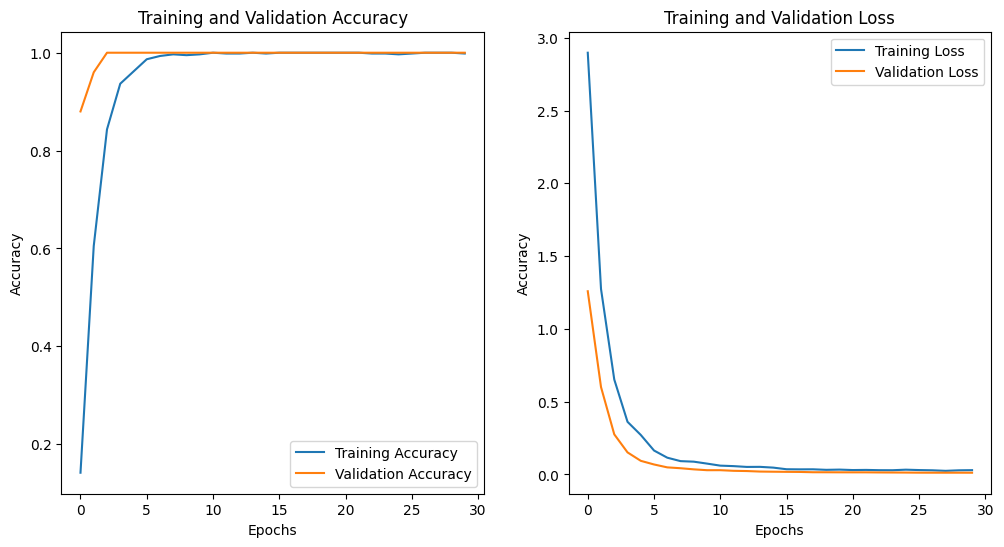

In [29]:
#learning curve
def plot_learning_curve(history):
    epochs = range(len(history.history['accuracy']))

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

plot_learning_curve(mnethistory)

10/10 [==============================] - 1s 86ms/step


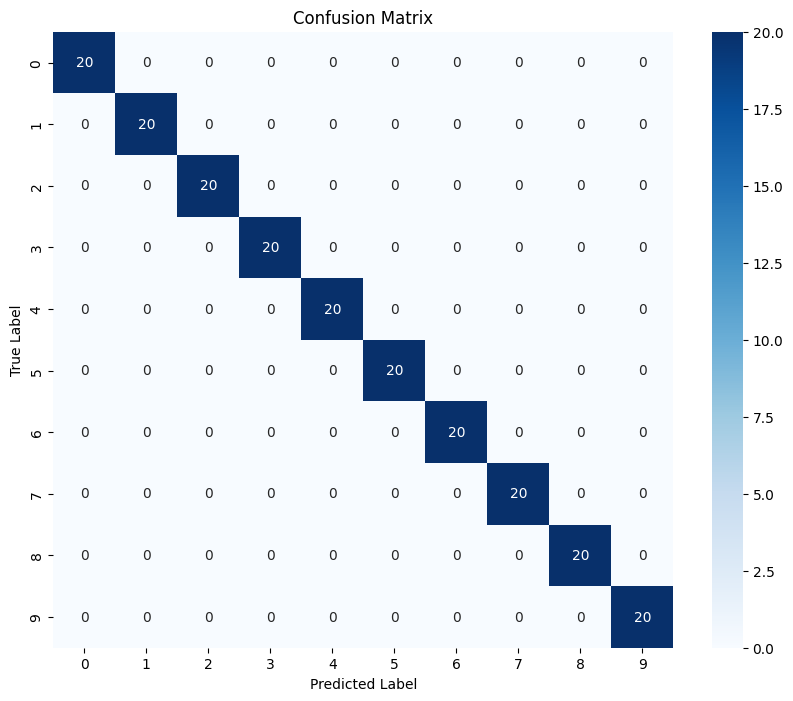

In [30]:
#confusion matrix
# Calculate the correct number of steps per epoch for evaluation or prediction
test_steps_per_epoch = np.ceil(test_generator.samples / test_generator.batch_size)

# Use the calculated steps per epoch for prediction
Y_pred = mnetmodel.predict(test_generator, steps=test_steps_per_epoch)

# Convert predictions to one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis=1)
# Get the true classes
Y_true = test_generator.classes

# Compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [32]:
report = classification_report(Y_true, Y_pred_classes, target_names=encoder.classes_)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

   Input - 0       1.00      1.00      1.00        20
   Input - 1       1.00      1.00      1.00        20
   Input - 2       1.00      1.00      1.00        20
   Input - 3       1.00      1.00      1.00        20
   Input - 4       1.00      1.00      1.00        20
   Input - 5       1.00      1.00      1.00        20
   Input - 6       1.00      1.00      1.00        20
   Input - 7       1.00      1.00      1.00        20
   Input - 8       1.00      1.00      1.00        20
   Input - 9       1.00      1.00      1.00        20

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



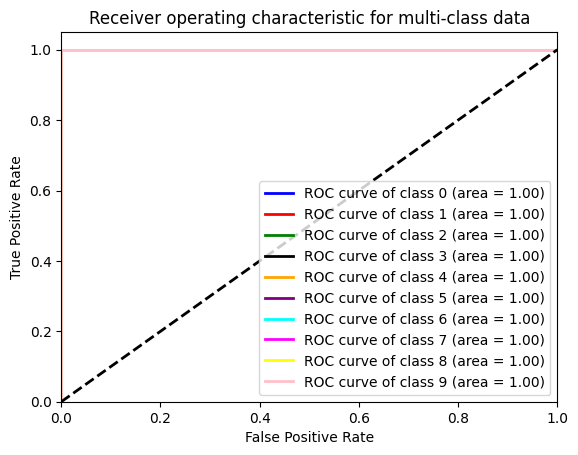

In [46]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
Y_true = lb.fit_transform(Y_true)

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = Y_true.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_true[:, i], Y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting each class ROC Curve
colors = cycle(['blue', 'red', 'green', 'black', 'orange', 'purple', 'cyan', 'magenta', 'yellow', 'pink'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

In [34]:
for layer in mnetmodel.layers:
    print(layer.name)

input_1
conv1
conv1_bn
conv1_relu
conv_dw_1
conv_dw_1_bn
conv_dw_1_relu
conv_pw_1
conv_pw_1_bn
conv_pw_1_relu
conv_pad_2
conv_dw_2
conv_dw_2_bn
conv_dw_2_relu
conv_pw_2
conv_pw_2_bn
conv_pw_2_relu
conv_dw_3
conv_dw_3_bn
conv_dw_3_relu
conv_pw_3
conv_pw_3_bn
conv_pw_3_relu
conv_pad_4
conv_dw_4
conv_dw_4_bn
conv_dw_4_relu
conv_pw_4
conv_pw_4_bn
conv_pw_4_relu
conv_dw_5
conv_dw_5_bn
conv_dw_5_relu
conv_pw_5
conv_pw_5_bn
conv_pw_5_relu
conv_pad_6
conv_dw_6
conv_dw_6_bn
conv_dw_6_relu
conv_pw_6
conv_pw_6_bn
conv_pw_6_relu
conv_dw_7
conv_dw_7_bn
conv_dw_7_relu
conv_pw_7
conv_pw_7_bn
conv_pw_7_relu
conv_dw_8
conv_dw_8_bn
conv_dw_8_relu
conv_pw_8
conv_pw_8_bn
conv_pw_8_relu
conv_dw_9
conv_dw_9_bn
conv_dw_9_relu
conv_pw_9
conv_pw_9_bn
conv_pw_9_relu
conv_dw_10
conv_dw_10_bn
conv_dw_10_relu
conv_pw_10
conv_pw_10_bn
conv_pw_10_relu
conv_dw_11
conv_dw_11_bn
conv_dw_11_relu
conv_pw_11
conv_pw_11_bn
conv_pw_11_relu
conv_pad_12
conv_dw_12
conv_dw_12_bn
conv_dw_12_relu
conv_pw_12
conv_pw_12_bn
conv_pw